In [59]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

import pints

class LinearModel(pints.ForwardModel):
    
    def simulate(self, parameters, times):
        
        y = parameters[0] + parameters[1]*times
        return y.reshape(times.shape)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

class PolyModel(pints.ForwardModel):
    
    def simulate(self, parameters, times):
        
        y = parameters[0] + (parameters[1]*parameters[2])*times**2
        return y.reshape(times.shape)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 3
# Then create an instance of our new model class
model_1 = LinearModel()
model_2 = PolyModel()

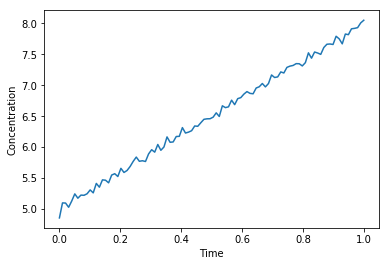

In [60]:
true_parameters = [5, 3]
times = np.linspace(0, 1, 100)
# Run a simulation to get test data
values = model_1.simulate(true_parameters, times)

# Add some noise
values += np.random.normal(0, 0.05, values.shape)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)
plt.show()

In [61]:
problem_1 = pints.SingleOutputProblem(model_1, times, values)
problem_2 = pints.SingleOutputProblem(model_2, times, values)

In [62]:
sigma_noise = 0.05
log_likelihood_1 = pints.KnownNoiseLogLikelihood(problem_1, sigma_noise)
log_prior_1a = pints.NormalLogPrior(5.,0.5)
log_prior_1b = pints.NormalLogPrior(3.,0.5)
log_prior_1 = pints.ComposedLogPrior(log_prior_1a,log_prior_1b)
log_posterior_1 = pints.LogPosterior(log_likelihood_1, log_prior_1)

In [63]:
log_likelihood_2 = pints.KnownNoiseLogLikelihood(problem_2, sigma_noise)
log_prior_2a = pints.NormalLogPrior(5.,0.5)
log_prior_2b = pints.NormalLogPrior(1.75,0.5)
log_prior_2c = pints.NormalLogPrior(1.75,0.5)
log_prior_2 = pints.ComposedLogPrior(log_prior_2a,log_prior_2b,log_prior_2c)
log_posterior_2 = pints.LogPosterior(log_likelihood_2, log_prior_2)

In [64]:
nchains = 1

x1 = log_prior_1.sample(1)
mcmc_1 = pints.MCMCSampling(log_posterior_1, nchains, x1, method=pints.PopulationMCMC)
#mcmc.set_log_to_file('log.txt')
mcmc_1.set_log_to_screen(False)
mcmc_1.set_max_iterations(50000)
mcmc_1.set_parallel(True)

x2 = log_prior_2.sample(1)
mcmc_2 = pints.MCMCSampling(log_posterior_2, nchains, x2, method=pints.PopulationMCMC)
#mcmc.set_log_to_file('log.txt')
mcmc_2.set_log_to_screen(False)
mcmc_2.set_max_iterations(50000)
mcmc_2.set_parallel(True)

In [65]:
with np.errstate(all='ignore'):
    chains_1 = mcmc_1.run()
    chains_2 = mcmc_2.run()

In [79]:
burnin = 30000
chains1 = chains_1[:, burnin:, :][0]
chains2 = chains_2[:, burnin:, :][0]

In [80]:
#chains01=chains[0]

In [81]:
def thermo_int(chains, n_params):

    ti=np.linspace(0,1,10)**5
    Eloglike_std = np.mean(chains[:,n_params:],axis=0); # E_theta|y,t log[p(y|theta)], integrand for I1
    E2loglike_std = np.mean(chains[:,n_params:]**2,axis=0);
    Vloglike_std = E2loglike_std - (np.mean(chains[:,n_params:],axis=0))**2; # Friel correction
    I_MC = 0
    for i in xrange(len(ti)-1):
        I_MC += (Eloglike_std[i] + Eloglike_std[i+1])/2 * (ti[i+1]-ti[i]) \
                - (Vloglike_std[i+1] - Vloglike_std[i])/12 * (ti[i+1]-ti[i])**2
    return I_MC

In [82]:
M_like_1 = thermo_int(chains1, 2)
M_like_2 = thermo_int(chains2, 3)
print('Marginal likelihood for model 1 is:', M_like_1)
print('Marginal likelihood for model 2 is:', M_like_2)

Marginal likelihood for model 1 is: 81.3966870748531
Marginal likelihood for model 2 is: -417.4346694615614


In [83]:
def plot_fit(chains, problem):
    
    new_values = []
    for params in chains[:400]:
        new_values.append(problem.evaluate(params[:3]))
    new_values = np.array(new_values)
    mean_values = np.mean(new_values, axis=0)

    # Plot them
    plt.figure(figsize=(15, 7.5))
    plt.plot(times, new_values[0], color='red', lw=2, label='inferred series')
    for v in new_values[1:]:
        plt.plot(times, v, color='red', lw=2)
    #plt.plot(times, mean_values, color='black', lw=2, label='mean inferred')

    plt.plot(times, values, 'o', color='#7f7f7f', ms=6.5, label='data points')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

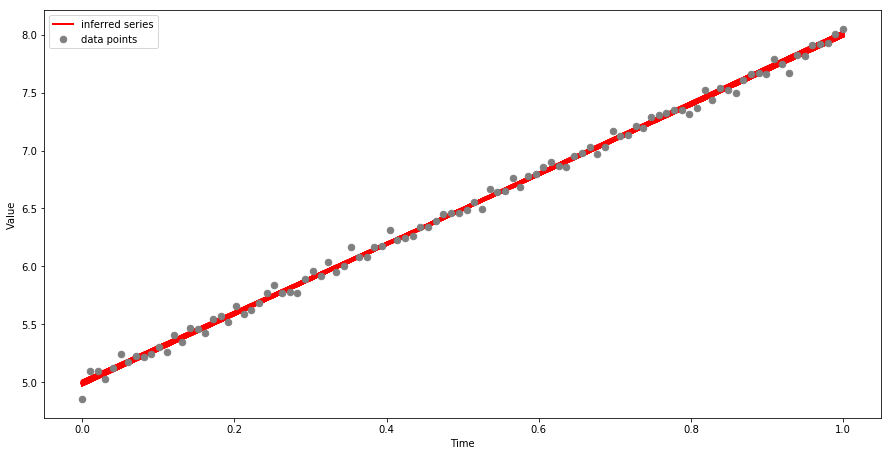

In [84]:
plot_fit(chains1, problem_1)

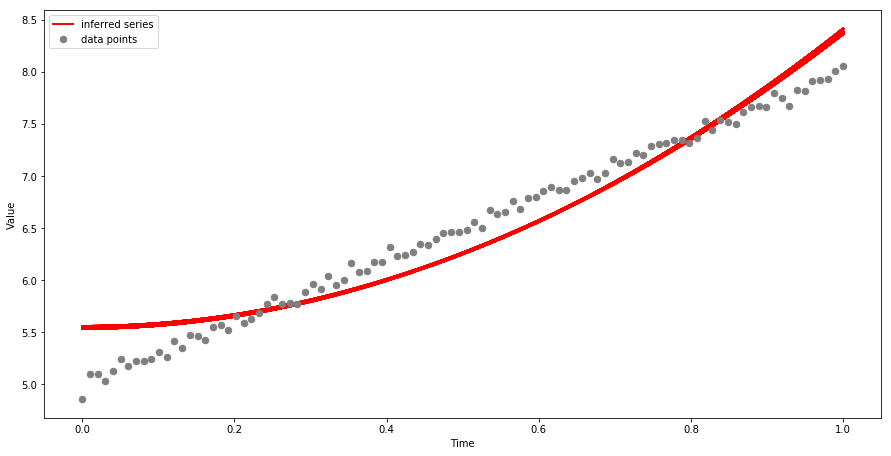

In [85]:
plot_fit(chains2, problem_2)

(<matplotlib.figure.Figure at 0x7f5fa617f210>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fa73e86d0>,
       dtype=object))

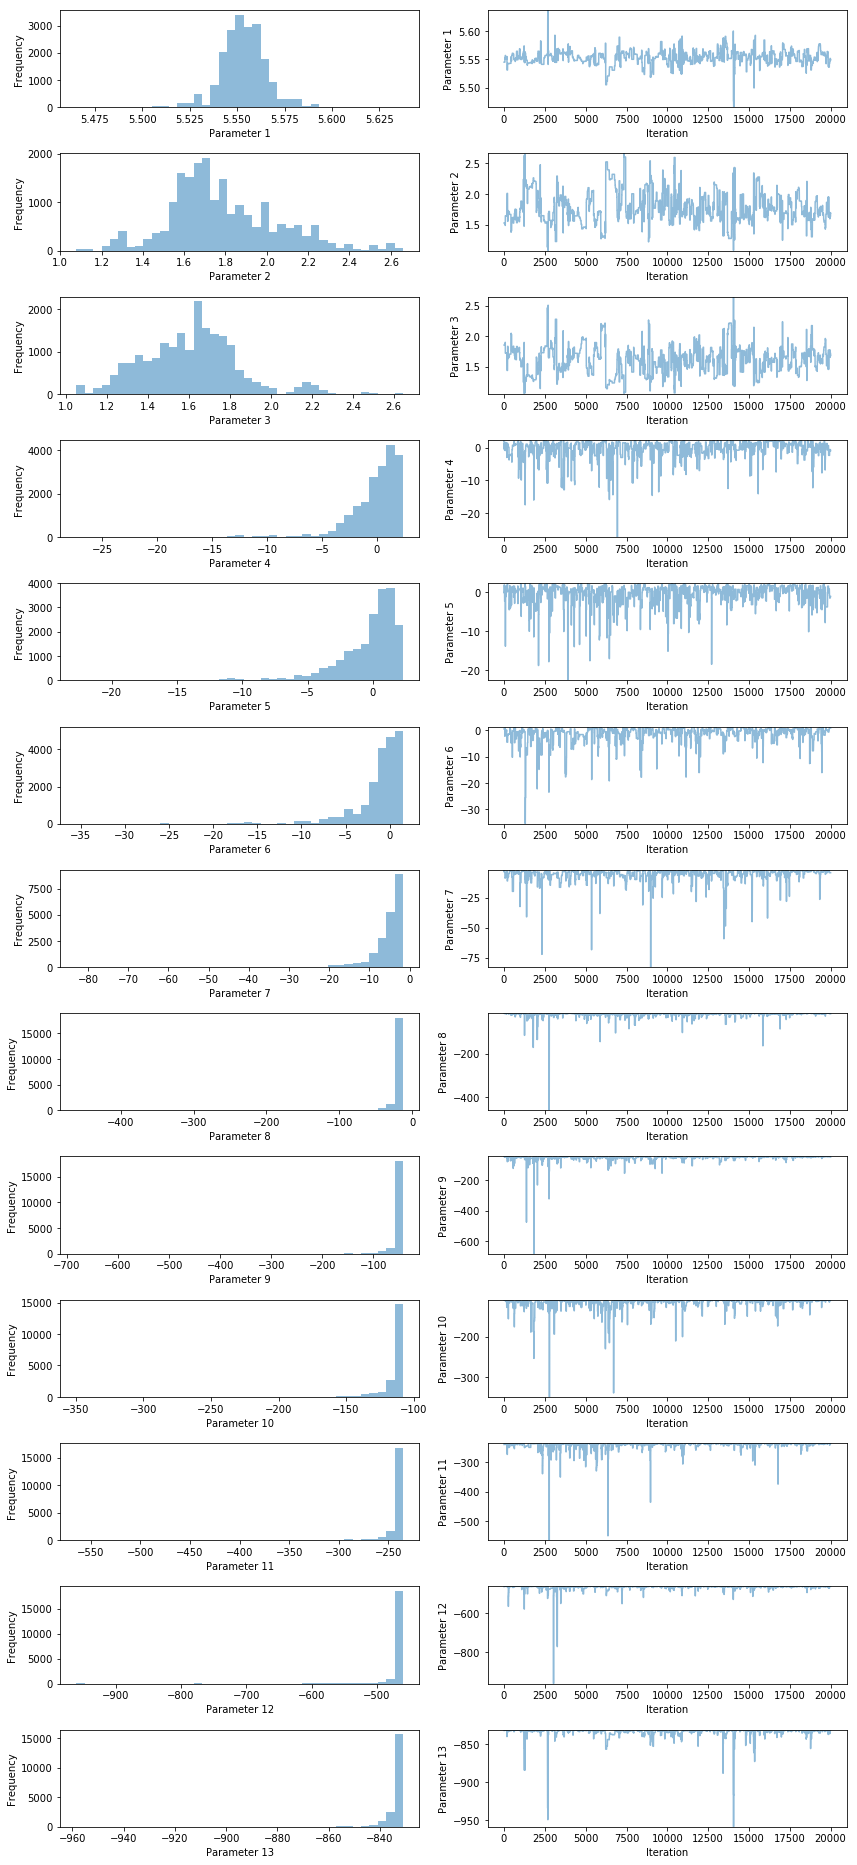

In [87]:
import pints.plot as pplot
pplot.trace(chains_2[:, burnin:, :])